<a href="https://colab.research.google.com/github/ungikim/DataEngineerChallenge/blob/master/PayPay_Data_Engineer_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DataEngineerChallenge

This is an interview challenge for PayPay

The challenge is to make make analytical observations about the data using the distributed tools below.

## Processing & Analytical goals:

* Sessionize the web log by IP. Sessionize = aggregrate all page hits by visitor/IP during a session. https://en.wikipedia.org/wiki/Session_(web_analytics)
* Determine the average session time
* Determine unique URL visits per session. To clarify, count a hit to a unique URL only once per session.
* Find the most engaged users, ie the IPs with the longest session times

## Hmm

### What is the appropriate session time?

* Paypay suggest 15 min
* Google Analytics use 30 min (default: They can change session length from few seconds to days)
* My guess: From the logs, this is the PayTM log. PayTM is an online shopping mall. According Spinutech, the industry standard is 2 - 3 minutes.

### How to filter out weird requests?

* Attack requests against the server
* Data cleansing is important because data can be used for machine learning

## Tools Used

* Spark
* Spark SQL
* Pyspark
* Jupyter Notebook (on Google Colab)

# Set up Environment

## Download data

In [0]:
!wget -q https://github.com/ungikim/DataEngineerChallenge/raw/master/data/2015_07_22_mktplace_shop_web_log_sample.log.gz

## Installation of Apache Spark on Google Colab

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
!tar xf spark-2.4.3-bin-hadoop2.7.tgz
!pip install -q findspark

## Set up Pyspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Check the Environment

In [6]:
import sys

print(f'Python Version: {sys.version}')
print(f'Spark Version: {spark._sc.version}')

Python Version: 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Spark Version: 2.4.3


# Processing

## Load Data

[See this](https://docs.aws.amazon.com/elasticloadbalancing/latest/classic/access-log-collection.html#access-log-entry-format)

In [0]:
from pyspark.sql.types import StructField, StructType, StringType, TimestampType, DoubleType, IntegerType

ELB_SCHEMA = StructType(
    [
        StructField("timestamp", TimestampType(), False),
        StructField("elb", StringType(), False),
        StructField("client", StringType(), False),
        StructField("backend", StringType(), False),
        StructField("request_processing_time", DoubleType(), False),
        StructField("backend_processing_time", DoubleType(), False),
        StructField("response_processing_time", DoubleType(), False),
        StructField("elb_status_code", IntegerType(), False),
        StructField("backend_status_code", IntegerType(), False),
        StructField("received_bytes", IntegerType(), False),
        StructField("sent_bytes", IntegerType(), False),
        StructField("request", StringType(), False),
        StructField("user_agent", StringType(), False),
        StructField("ssl_cipher", StringType(), False),
        StructField("ssl_protocol", StringType(), False),

    ]
)

df = spark.read.csv("file:///content/2015_07_22_mktplace_shop_web_log_sample.log.gz", schema=ELB_SCHEMA, sep=" ")

## Extra Transformation for Analysis

* Isolate the columns for convenience
* Extra data for User Agent (using [user-agents](https://pypi.org/project/user-agents/))

In [8]:
!pip install user-agents

  Stored in directory: /root/.cache/pip/wheels/48/41/70/1ba4d8c9bbca8a54fac6827bc7c48c93d5b44d94829facecba
Successfully built user-agents


In [0]:
from contextlib import suppress
from typing import Optional, Text

from pyspark.sql import functions as F
from user_agents import parse

@F.udf
def udf_user_agent_info(user_agent: Text) -> Optional[Text]:
    with suppress(Exception):
        return str(parse(user_agent))
    return None


In [10]:
df = df.withColumn("client_ip", F.split(df["client"], ":")[0]).withColumn("client_port", F.split(df["client"], ":")[1]).drop("client")
df = df.withColumn("backend_ip", F.split(df["backend"], ":")[0]).withColumn("backend_port", F.split(df["backend"], ":")[1]).drop("backend")
df = df.withColumn("request_method", F.split(df["request"], " ")[0]).withColumn("request_url", F.split(df["request"], " ")[1]).withColumn("request_protocol", F.split(df["request"], " ")[2]).drop("request")
df = df.withColumn("user_agent_info", udf_user_agent_info("user_agent"))
df.cache() # if you need

DataFrame[timestamp: timestamp, elb: string, request_processing_time: double, backend_processing_time: double, response_processing_time: double, elb_status_code: int, backend_status_code: int, received_bytes: int, sent_bytes: int, user_agent: string, ssl_cipher: string, ssl_protocol: string, client_ip: string, client_port: string, backend_ip: string, backend_port: string, request_method: string, request_url: string, request_protocol: string, user_agent_info: string]

## Register Table for EDA and Data Summary

In [0]:
df.createOrReplaceTempView("elb")

In [12]:
df.describe().show()

+-------+----------------+-----------------------+-----------------------+------------------------+------------------+-------------------+------------------+-----------------+--------------------+--------------------+------------+------------+------------------+----------+-------------------+--------------+--------------------+----------------+--------------------+
|summary|             elb|request_processing_time|backend_processing_time|response_processing_time|   elb_status_code|backend_status_code|    received_bytes|       sent_bytes|          user_agent|          ssl_cipher|ssl_protocol|   client_ip|       client_port|backend_ip|       backend_port|request_method|         request_url|request_protocol|     user_agent_info|
+-------+----------------+-----------------------+-----------------------+------------------------+------------------+-------------------+------------------+-----------------+--------------------+--------------------+------------+------------+------------------+--

## EDA

In [13]:
# Check for Duplicates

original_cnt = df.count()
distinct_cnt = df.select("timestamp", "elb", "client_ip", "client_port", "backend_ip", "backend_port", "request_method", "request_url").distinct().count()
print(original_cnt, distinct_cnt)

1158500 1158500


In [14]:
spark.sql("""
SELECT
    client_ip,
    COUNT(DISTINCT session_id_30) AS cnt_session_30,
    COUNT(DISTINCT session_id_15) AS cnt_session_15,
    COUNT(DISTINCT session_id_3) AS cnt_session_3
FROM (
    SELECT
        CONCAT_WS(
            '_',
            client_ip,
            CAST(SUM(CASE
                    WHEN COALESCE(UNIX_TIMESTAMP(timestamp) - UNIX_TIMESTAMP(LAG(timestamp, 1) OVER (PARTITION BY client_ip ORDER BY timestamp)), 0) > 30 * 60 THEN 1
                    ELSE 0
                END) OVER (PARTITION BY client_ip ORDER BY timestamp)
            AS STRING)
        ) AS session_id_30,
        CONCAT_WS(
            '_',
            client_ip,
            CAST(SUM(CASE
                    WHEN COALESCE(UNIX_TIMESTAMP(timestamp) - UNIX_TIMESTAMP(LAG(timestamp, 1) OVER (PARTITION BY client_ip ORDER BY timestamp)), 0) > 15 * 60 THEN 1
                    ELSE 0
                END) OVER (PARTITION BY client_ip ORDER BY timestamp)
            AS STRING)
        ) AS session_id_15,
        CONCAT_WS(
            '_',
            client_ip,
            CAST(SUM(CASE
                    WHEN COALESCE(UNIX_TIMESTAMP(timestamp) - UNIX_TIMESTAMP(LAG(timestamp, 1) OVER (PARTITION BY client_ip ORDER BY timestamp)), 0) > 3 * 60 THEN 1
                    ELSE 0
                END) OVER (PARTITION BY client_ip ORDER BY timestamp)
            AS STRING)
        ) AS session_id_3,
        timestamp,
        request_url,
        user_agent,
        client_ip
    FROM
        elb
)
GROUP BY
    1
HAVING
    COUNT(DISTINCT session_id_15) != COUNT(DISTINCT session_id_30)
    OR
    COUNT(DISTINCT session_id_3) != COUNT(DISTINCT session_id_15)
ORDER BY
    4 DESC
""").show(10)

+--------------+--------------+--------------+-------------+
|     client_ip|cnt_session_30|cnt_session_15|cnt_session_3|
+--------------+--------------+--------------+-------------+
|  54.232.40.76|             8|             8|           32|
|  207.46.13.22|             8|             8|           30|
|54.252.254.204|             8|             8|           30|
|176.34.159.236|             8|             8|           29|
| 54.241.32.108|             8|             8|           29|
| 107.23.255.12|             8|             8|           28|
| 54.248.220.44|             8|             8|           28|
|54.250.253.236|             8|             8|           28|
| 54.252.79.172|             7|             7|           28|
|54.183.255.140|             8|             8|           28|
+--------------+--------------+--------------+-------------+
only showing top 10 rows



## Sessionize the web log by IP

Sessionize = aggregrate all page hits by visitor/IP during a fixed time window.

In [15]:
from pyspark.sql import Window

session_criteria = Window.partitionBy("client_ip").orderBy("timestamp")

df = df.withColumn(
    "session_id",
    F.concat_ws(
        "_",
        df["client_ip"],
        F.sum(
            F.when(
                F.coalesce(
                    F.unix_timestamp(df["timestamp"])
                    - F.lag(F.unix_timestamp(df["timestamp"]), 1).over(
                        session_criteria
                    ),
                    F.lit(0),
                )
                > 3 * 60,
                1,
            ).otherwise(0)
        ).over(session_criteria)
    )
)
df.cache()

DataFrame[timestamp: timestamp, elb: string, request_processing_time: double, backend_processing_time: double, response_processing_time: double, elb_status_code: int, backend_status_code: int, received_bytes: int, sent_bytes: int, user_agent: string, ssl_cipher: string, ssl_protocol: string, client_ip: string, client_port: string, backend_ip: string, backend_port: string, request_method: string, request_url: string, request_protocol: string, user_agent_info: string, session_id: string]

## Write to parquet

In [0]:
df.write.parquet("file:///content/transformed_elb", mode="overwrite")

# Analysis

- Determine the average session time
- Determine unique URL visits per session. To clarify, count a hit to a unique URL only once per session.
- Find the most engaged users, ie the IPs with the longest session times

## Register table for Analysis

In [0]:
spark.read.parquet("file:///content/transformed_elb").cache().createOrReplaceTempView("transformed_elb")

## Determine the average session time

In [18]:
spark.sql("""
SELECT 
    SUM(total_session_time_per_ip) AS amount_of_time, 
    SUM(num_of_sessions_per_ip) AS num_of_sessions,
    AVG(num_of_sessions_per_ip) AS average_num_of_sessions,
    (SUM(total_session_time_per_ip) / SUM(num_of_sessions_per_ip)) / 60 AS average_session_time_in_mins
FROM (
    SELECT
        client_ip,
        COUNT(DISTINCT session_id) AS num_of_sessions_per_ip,
        SUM(session_time) AS total_session_time_per_ip
    FROM (
        SELECT
            client_ip,
            session_id,
            MAX(UNIX_TIMESTAMP(timestamp)) - MIN(UNIX_TIMESTAMP(timestamp)) AS session_time
        FROM
            transformed_elb
        WHERE
            request_processing_time != -1 OR backend_processing_time != -1 OR request_processing_time != -1
        GROUP BY
            1, 2
    )
    GROUP BY
        1
)
""").show()

+--------------+---------------+-----------------------+----------------------------+
|amount_of_time|num_of_sessions|average_num_of_sessions|average_session_time_in_mins|
+--------------+---------------+-----------------------+----------------------------+
|      28962478|         204762|     2.2615889285280377|          2.3574099035302774|
+--------------+---------------+-----------------------+----------------------------+



In [0]:
pdf = spark.sql("""
SELECT 
    *
FROM (
    SELECT
        client_ip,
        COUNT(DISTINCT session_id) AS num_of_sessions_per_ip,
        SUM(session_time) AS total_session_time_per_ip
    FROM (
        SELECT
            client_ip,
            session_id,
            MAX(UNIX_TIMESTAMP(timestamp)) - MIN(UNIX_TIMESTAMP(timestamp)) AS session_time
        FROM
            transformed_elb
        WHERE
            request_processing_time != -1 OR backend_processing_time != -1 OR request_processing_time != -1
        GROUP BY
            1, 2
    )
    GROUP BY
        1
)
""").toPandas()

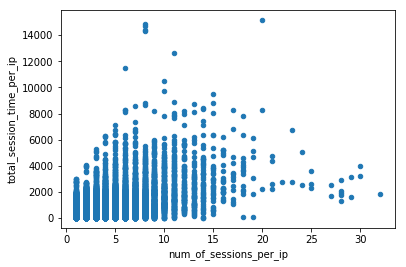

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

ax1 = pdf.plot(kind="scatter", x="num_of_sessions_per_ip", y="total_session_time_per_ip")
plt.show()

## Determine unique URL visits per session. To clarify, count a hit to a unique URL only once per session.

Recods of static file access are not counted as visits.

In [21]:
spark.sql("""
SELECT
    SUM(total_unique_visits) / SUM(total_sessions_per_ip) AS average_unique_visits_per_session
FROM (
    SELECT
        client_ip,
        COUNT(DISTINCT session_id) AS total_sessions_per_ip,
        COUNT(request_url) AS total_unique_visits,
        COUNT(request_url) / COUNT(DISTINCT session_id)  AS unique_visits_per_session
    FROM (
        SELECT
            client_ip,
            session_id,
            request_url
        FROM
            transformed_elb
        WHERE
                PARSE_URL(request_url, 'PATH') NOT RLIKE '^([\\S]+(\\.(?i)(jpg|png|gif|css|js|xml|webp|ico|eot|woff|php|txt|svg))$)'
            AND (request_processing_time != -1 OR backend_processing_time != -1 OR request_processing_time != -1)
        GROUP BY
            1, 2, 3
    )
    GROUP BY
        1
)
""").show()

+---------------------------------+
|average_unique_visits_per_session|
+---------------------------------+
|                4.665264957264958|
+---------------------------------+



## Find the most engaged users, ie the IPs with the longest session times

In [22]:
spark.sql("""
SELECT
    client_ip,
    session_id,
    (MAX(unix_timestamp(timestamp)) - MIN(unix_timestamp(timestamp))) / 60 AS session_time_in_mins
FROM
    transformed_elb
WHERE
    request_processing_time != -1 OR backend_processing_time != -1 OR request_processing_time != -1
GROUP BY
    1, 2
ORDER BY
    3 DESC
""").show(50)

+---------------+-----------------+--------------------+
|      client_ip|       session_id|session_time_in_mins|
+---------------+-----------------+--------------------+
|   52.74.219.71|   52.74.219.71_5|                50.7|
|  119.81.61.166|  119.81.61.166_5|               50.65|
|   52.74.219.71|   52.74.219.71_4|                50.5|
|  54.251.151.39|  54.251.151.39_4|  50.483333333333334|
| 103.29.159.186| 103.29.159.186_1|                50.4|
|  119.81.61.166|  119.81.61.166_4|   50.36666666666667|
| 103.29.159.138| 103.29.159.138_0|   50.11666666666667|
|  122.169.141.4|  122.169.141.4_0|   50.03333333333333|
|  106.186.23.95|  106.186.23.95_5|  49.983333333333334|
| 122.248.183.22| 122.248.183.22_5|   49.96666666666667|
|  106.186.23.95|  106.186.23.95_4|               49.95|
| 103.29.159.213| 103.29.159.213_1|   49.81666666666667|
|  199.43.186.25|  199.43.186.25_7|  49.733333333333334|
| 121.58.175.128| 121.58.175.128_6|  49.733333333333334|
|  103.29.159.62|  103.29.159.6

## Session length outlier detection

In [37]:
sdf = spark.sql("""
SELECT
    client_ip,
    session_id,
    (MAX(unix_timestamp(timestamp)) - MIN(unix_timestamp(timestamp))) / 60 AS session_time_in_mins
FROM
    transformed_elb
WHERE
    request_processing_time != -1 OR backend_processing_time != -1 OR request_processing_time != -1
GROUP BY
    1, 2
""")
q1, q3 = sdf.approxQuantile('session_time_in_mins', [0.25, 0.75], 0)
print(f"Q1: {q1}\nQ3: {q3}")

Q1: 0.0
Q3: 2.683333333333333


In [36]:
spark.sql(f"""
SELECT
    *
FROM (
    SELECT
        client_ip,
        session_id,
        (MAX(unix_timestamp(timestamp)) - MIN(unix_timestamp(timestamp))) / 60 AS session_time_in_mins
    FROM
        transformed_elb
    WHERE
        request_processing_time != -1 OR backend_processing_time != -1 OR request_processing_time != -1
    GROUP BY
        1, 2
)
WHERE
    session_time_in_mins > {q3}
ORDER BY
    3 DESC
""").show()

+--------------+----------------+--------------------+
|     client_ip|      session_id|session_time_in_mins|
+--------------+----------------+--------------------+
|  52.74.219.71|  52.74.219.71_5|                50.7|
| 119.81.61.166| 119.81.61.166_5|               50.65|
|  52.74.219.71|  52.74.219.71_4|                50.5|
| 54.251.151.39| 54.251.151.39_4|  50.483333333333334|
|103.29.159.186|103.29.159.186_1|                50.4|
| 119.81.61.166| 119.81.61.166_4|   50.36666666666667|
|103.29.159.138|103.29.159.138_0|   50.11666666666667|
| 122.169.141.4| 122.169.141.4_0|   50.03333333333333|
| 106.186.23.95| 106.186.23.95_5|  49.983333333333334|
|122.248.183.22|122.248.183.22_5|   49.96666666666667|
| 106.186.23.95| 106.186.23.95_4|               49.95|
|103.29.159.213|103.29.159.213_1|   49.81666666666667|
|121.58.175.128|121.58.175.128_6|  49.733333333333334|
| 199.43.186.25| 199.43.186.25_7|  49.733333333333334|
| 103.29.159.62| 103.29.159.62_0|                49.7|
|  103.4.1

## Browser and OS Report


In [24]:
spark.sql("""
SELECT
    SPLIT(SPLIT(user_agent_info, ' / ')[1], ' ')[0] AS os,
    SPLIT(SPLIT(user_agent_info, ' / ')[2], ' ')[0] AS browser,
    COUNT(*) AS request_cnt,
    COUNT(DISTINCT client_ip) AS distinct_user_cnt_not_guarantee
FROM
    transformed_elb
GROUP BY
    1, 2
ORDER BY
    4 DESC
""").show()

+----------+----------+-----------+-------------------------------+
|        os|   browser|request_cnt|distinct_user_cnt_not_guarantee|
+----------+----------+-----------+-------------------------------+
|   Windows|    Chrome|     576203|                          45729|
|   Windows|   Firefox|     150417|                          15551|
|   Android|    Chrome|      64343|                           9676|
|   Windows|        IE|      78355|                           7181|
|   Android|        UC|      39262|                           5378|
|   Android|   Android|      18773|                           2904|
|   Windows|     Opera|      14011|                           2086|
|       iOS|    Mobile|       8373|                           1607|
|   Android|     Opera|      18577|                           1239|
|       Mac|    Chrome|       8847|                            941|
|     Other|     Opera|      12602|                            904|
|     Other|        UC|      11204|             

# Download transformed data

In [42]:
!tar -zcvf transformed_elb.tar.gz transformed_elb

transformed_elb/
transformed_elb/part-00095-0ceffb42-61ad-4d56-a5f4-9ee6780cb1d1-c000.snappy.parquet
transformed_elb/part-00077-0ceffb42-61ad-4d56-a5f4-9ee6780cb1d1-c000.snappy.parquet
transformed_elb/part-00035-0ceffb42-61ad-4d56-a5f4-9ee6780cb1d1-c000.snappy.parquet
transformed_elb/.part-00169-0ceffb42-61ad-4d56-a5f4-9ee6780cb1d1-c000.snappy.parquet.crc
transformed_elb/part-00138-0ceffb42-61ad-4d56-a5f4-9ee6780cb1d1-c000.snappy.parquet
transformed_elb/.part-00105-0ceffb42-61ad-4d56-a5f4-9ee6780cb1d1-c000.snappy.parquet.crc
transformed_elb/part-00190-0ceffb42-61ad-4d56-a5f4-9ee6780cb1d1-c000.snappy.parquet
transformed_elb/.part-00189-0ceffb42-61ad-4d56-a5f4-9ee6780cb1d1-c000.snappy.parquet.crc
transformed_elb/part-00032-0ceffb42-61ad-4d56-a5f4-9ee6780cb1d1-c000.snappy.parquet
transformed_elb/.part-00040-0ceffb42-61ad-4d56-a5f4-9ee6780cb1d1-c000.snappy.parquet.crc
transformed_elb/part-00087-0ceffb42-61ad-4d56-a5f4-9ee6780cb1d1-c000.snappy.parquet
transformed_elb/part-00176-0ceffb42-61a

In [43]:
!ls -al

total 318252
drwxr-xr-x  1 root root      4096 Jun 28 08:47 .
drwxr-xr-x  1 root root      4096 Jun 28 06:04 ..
-rw-r--r--  1 root root  53832694 Jun 28 08:15 2015_07_22_mktplace_shop_web_log_sample.log.gz
drwxr-xr-x  1 root root      4096 Jun 18 16:14 .config
drwxr-xr-x  1 root root      4096 Jun 18 16:14 sample_data
drwxr-xr-x 13 1000 1000      4096 May  1 05:19 spark-2.4.3-bin-hadoop2.7
-rw-r--r--  1 root root 229988313 May  1 05:57 spark-2.4.3-bin-hadoop2.7.tgz
drwxr-xr-x  2 root root      4096 Jun 28 08:32 spark-warehouse
drwxr-xr-x  2 root root     49152 Jun 28 08:34 transformed_elb
-rw-r--r--  1 root root  41989009 Jun 28 08:47 transformed_elb.tar.gz


In [0]:
from google.colab import files
files.download('/content/transformed_elb.tar.gz') 